# This test compares a catenary composed of cables and bodies to the analytical solution


The analytical formula for a catenary is as follows:

Shape:
$$y = cosh(\frac{x}{a})$$

where

$$ a = \frac{T_0}{\lambda g} $$

Where ${T_0}$ is the horizontal force in a catenary which is constant.

The length of the catenary (s) equals:

$$ s = a \:sinh(\frac {x}{a}) $$

With the enpoints and length of the cable known, the unknown a can be solved numerically.

In these formulas s, x and y describe the catenary relative to its lowest point. 

Ref: https://en.wikipedia.org/wiki/Catenary


# Import the tools that we need

In [1]:
from DAVE import *
from DAVE.jupyter import *
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy import sinh, cosh, sqrt


default resource folders:
C:\Users\beneden\Miniconda3\envs\DAVE2\lib\site-packages\DAVE\resources
C:\Users\beneden\DAVE_models
Blender found at: C:\Program Files\Blender Foundation\Blender 2.82\blender.exe
embedWindow(verbose=True): could not load k3d module, try:
> pip install k3d      # and if necessary:
> conda install nodejs


## Define catenary properties

In [2]:
mass_per_lengh = 1
length = 80
EA = 1e9    # <-- should be a high number as the analytical equation does not account for stretch
segments = 100
width = 60

## Solve the analytical formulas numerically

In [3]:
# We know the width and length of the catenary
# The standard formula for a catenary describe half of a symmetric catenary

s =  length / 2
x =  width / 2

# solve s = a sinh(x/a)

def should_be_zero(a):
    return a * sinh(x/a) - s

a_guess = 1
a = fsolve(should_be_zero, a_guess)

T0 = a * mass_per_lengh * 9.81

print(f'T0 (horizontal tension = {T0}')

T0 (horizontal tension = [217.7983993]


## Solve using DAVE

In [4]:
s = Scene()
p1 = s.new_point('p1',position=(-width/2,0,0))
p2 = s.new_point('p2',position=(width/2,0,0))

# construct the catenary


mass_per_body = mass_per_lengh * length / segments

for i in range(segments):
    b = s.new_rigidbody(name = f'body{i}', mass = mass_per_body,
                        fixed=(False,True,False,True,True,True))  # only free in X and Z
    s.new_point(f'point{i}', parent=b)

for i in range(segments-1):
    s.new_cable(f'cable{i}',
                endA = f'point{i}',
                endB = f'point{i+1}',
                length = length/segments,
                EA = EA)

s.new_cable(f'cable_left',
            endA = 'p1',
            endB = 'point0',
            length = 0.5*length/segments,
            EA = EA)

s.new_cable(f'cable_right',
            endA = f'point{segments-1}',
            endB = 'p2',
            length = 0.5*length/segments,
            EA = EA);


s.solve_statics()

Solved to 3.465170165029008e-06.


True

## Compare

### Horizontal tension at endpoints

In [5]:
# Check horizontal tension at the endpoints

T0_p1 = s['p1'].applied_force_and_moment_global[0]
T0_p2 = -s['p2'].applied_force_and_moment_global[0]

print(f'End 1 = {T0_p1}')
print(f'End 2 = {T0_p2}')
print(f'Expected = {T0}')

End 1 = 217.80839631801223
End 2 = 217.8083952387749
Expected = [217.7983993]


## Horizontal force difference in catenary

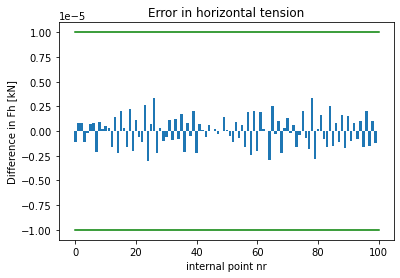

In [6]:
# Check the horizontal tension in the cable
# Two cables are connected to each of the internal points. Both cables should have the same horizontal
# tension and pull in opposite direction. Hence the total horizontal force on each of the internal pois
# should be zero

fx = []
for i in range(segments):
    point = s[f'point{i}']
    fx.append(point.applied_force_and_moment_global[0])

y = 1e-5
    
plt.bar(range(segments),fx)
plt.plot((0, segments),(y,y),'g-')
plt.plot((0, segments),(-y,-y),'g-')

plt.title('Error in horizontal tension')
plt.ylabel('Difference in Fh [kN]')
plt.xlabel('internal point nr');

## Horizontal force in catenary

Text(0.5, 0, 'internal cable nr')

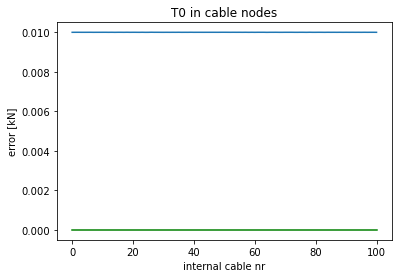

In [7]:
# we can also get the horizontal component from the cable tension
# and the cable direction
T0_cables_error = []

for cable in s.nodes_of_type(Cable):
    tension = cable.tension
    endA = cable.connections[0]  # the the endpoints
    endB = cable.connections[1]

    dx = endB.gx - endA.gx        # the horizontal distance
    dz = endB.gz - endA.gz
    ds = sqrt(dx*dx + dz*dz)

    Th = tension * dx / ds

    T0_cables_error.append(Th - T0)

plt.plot(T0_cables_error)
plt.plot((0, segments),(0,0),'g-')
plt.title('T0 in cable nodes')
plt.ylabel('error [kN]')
plt.xlabel('internal cable nr');


## Catenary shape

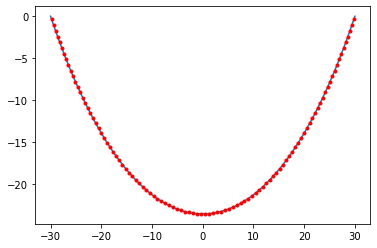

In [8]:
def y_analytical(x):
    return a * cosh(x/a)

xs = np.linspace(-x, x, num=100)
ys = y_analytical(xs)
y0 = y_analytical(x)

plt.plot(xs, ys-y0, label='analytical')

for b in s.nodes_of_type(RigidBody):
    plt.plot(b.gx, b.gz,'r.')

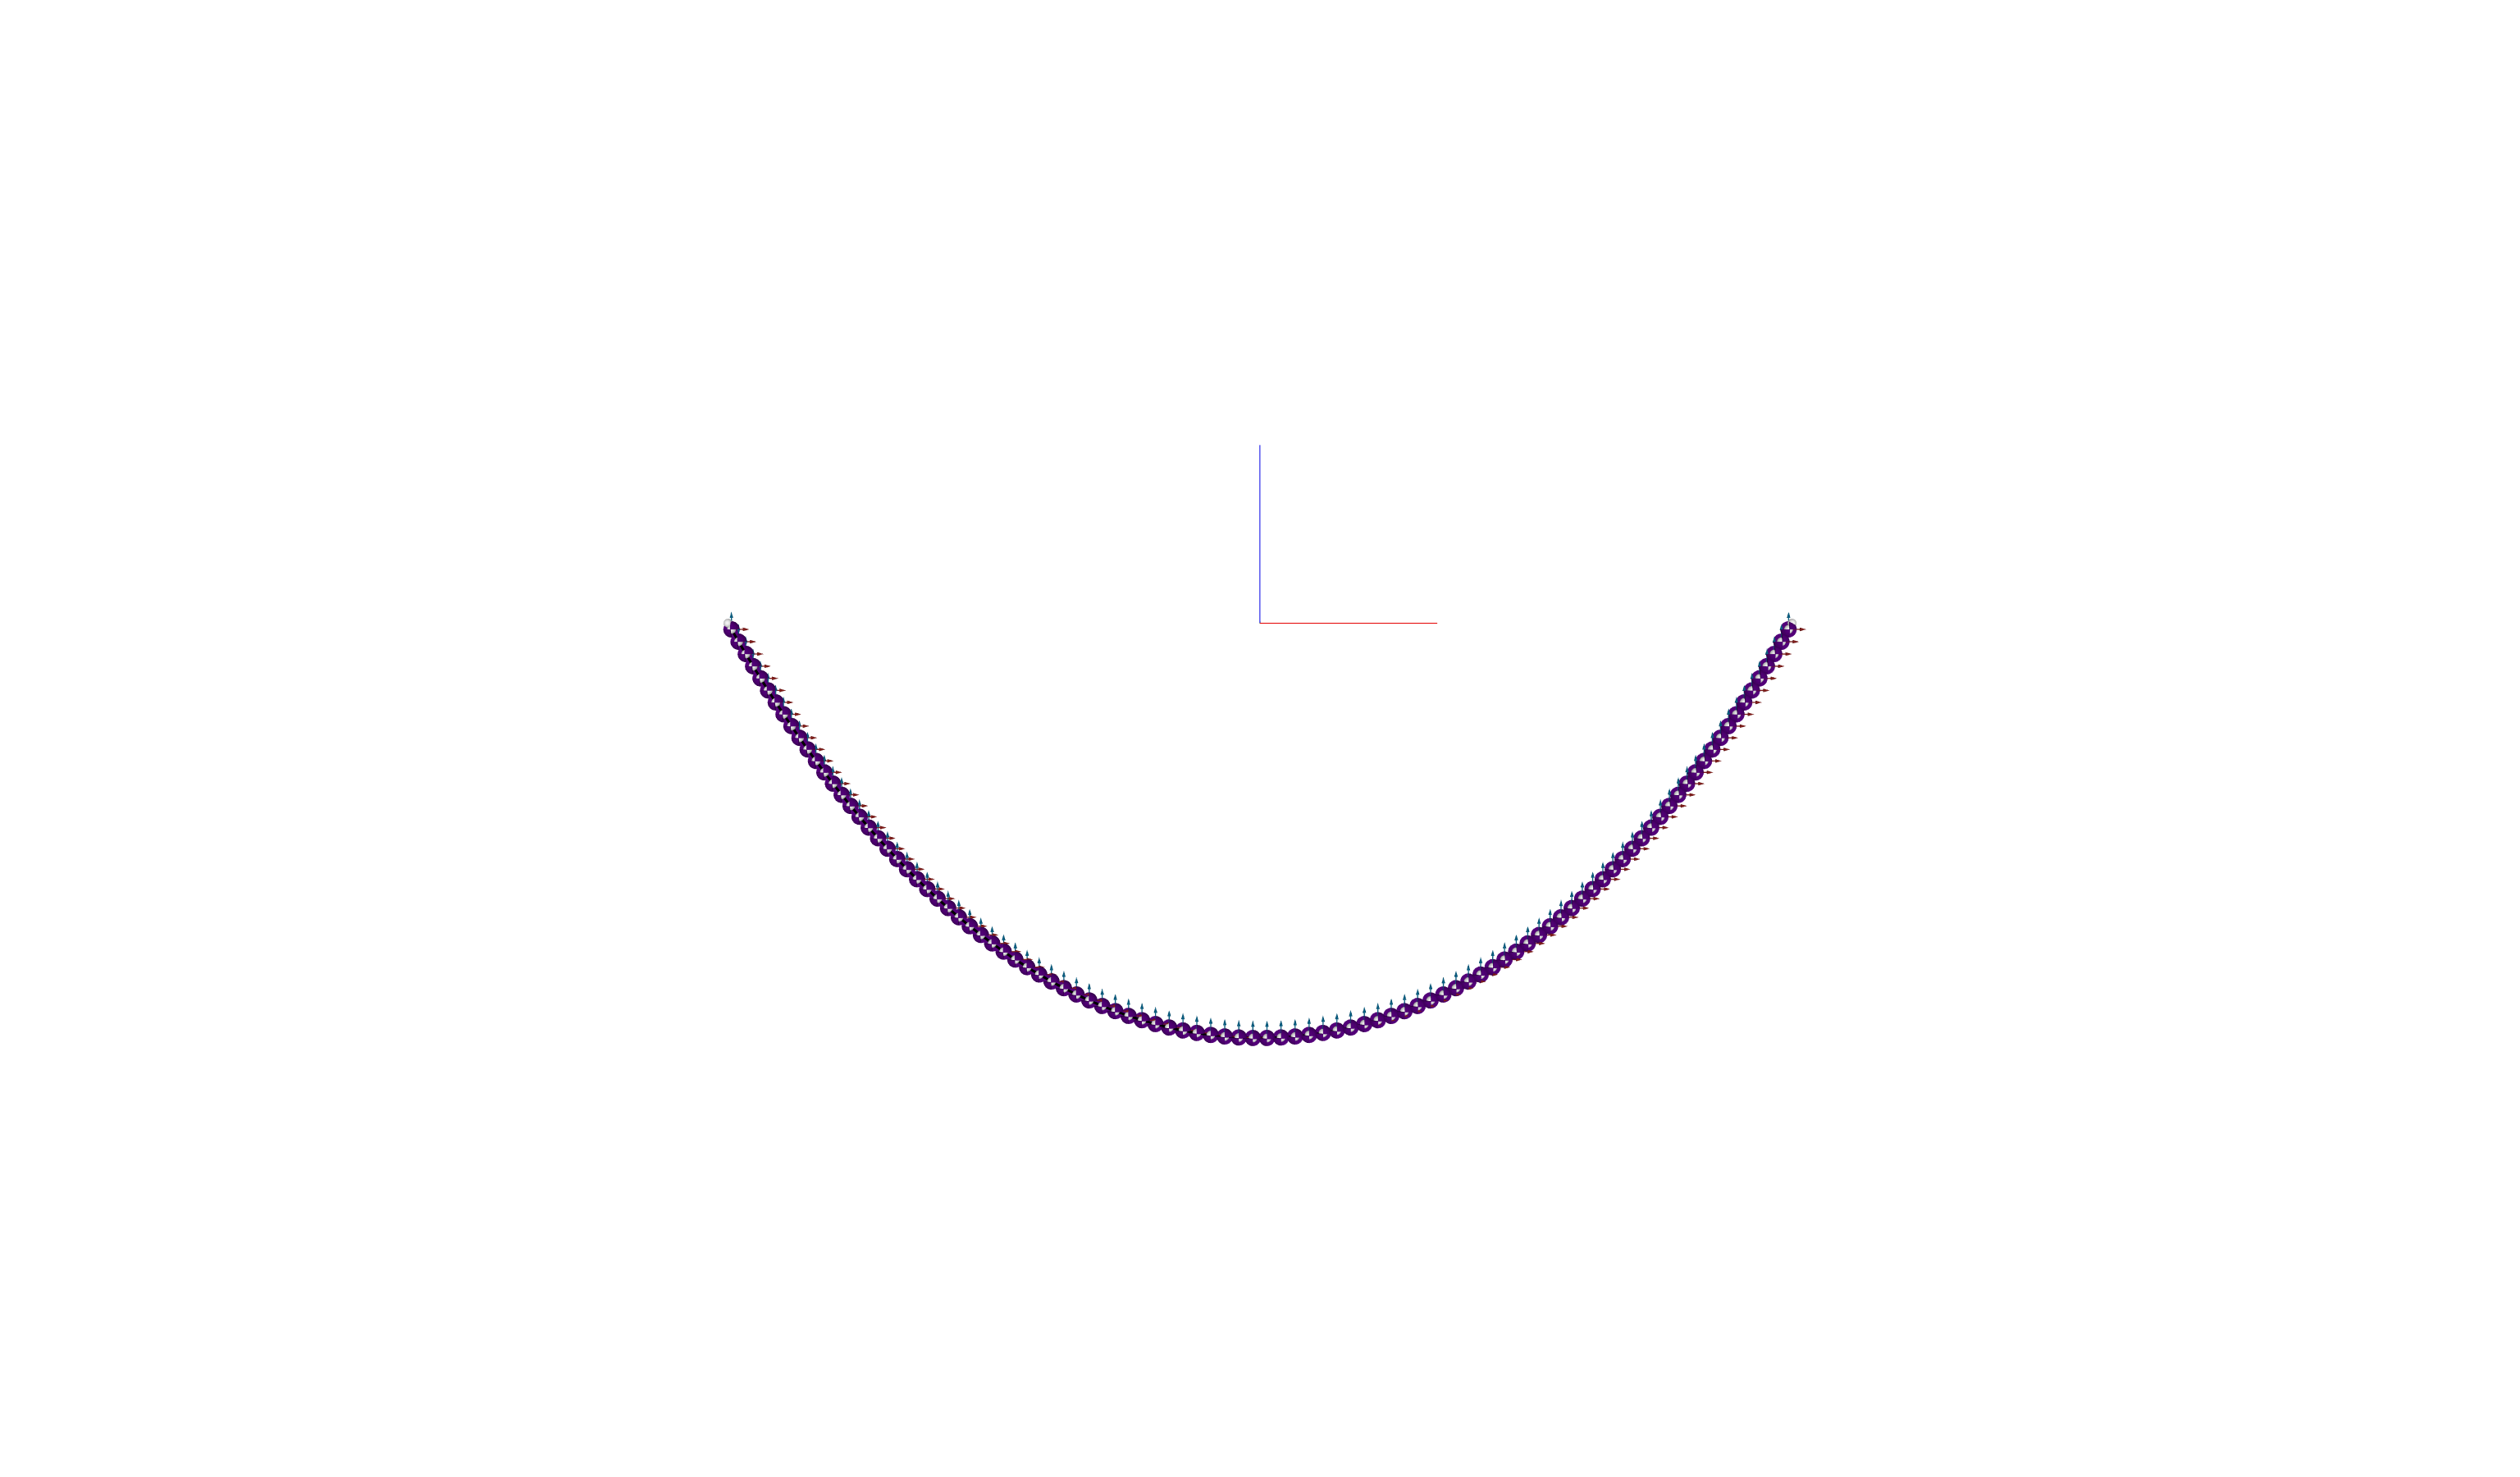

In [9]:
show(s, sea = False, camera_pos = (0.15395706315695745, -157.94371542848114, 1.5505097440465085), lookat = (0.0, 4.5, -6.740077863423391), force_normalize = True, force_scale = 1.6)